# Assignment 1 - Inpainting

Name: Thomas Buchegger<br>
Matriculation number: 13-474-101

In [1]:
from numpy import *
from PIL import Image
import matplotlib.pyplot as plt
from scipy import signal
from scipy import sparse

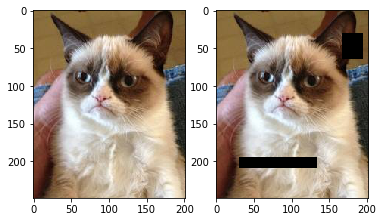

In [2]:
im = array(Image.open('grumpycat.jpeg')) / 256

# mask
h, w, _ = im.shape
omega = ones((h, w))
omega[195:209, 31:134] = 0
omega[31:65, 166:194] = 0

# create input image
omega3 = expand_dims(omega, 2)
g = im * omega3

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(im)
plt.subplot(1, 2, 2)
plt.imshow(g)

## (a) Gradient Descent

In [3]:
def GetSSD(uc, im):
    m, n, *_= uc.shape
    SSD = 0
    
    for i in range(m):
        for j in range(n):
            SSD += (im[:, :, 0][i,j]-uc[:, :, 0][i,j])**2
            SSD += (im[:, :, 1][i,j]-uc[:, :, 1][i,j])**2
            SSD += (im[:, :, 2][i,j]-uc[:, :, 2][i,j])**2
            
    return SSD

In [4]:
def GetEnergy(uc, gc, omega):

    energy  = 0 
    m,n,_=uc.shape
        
    for i in range(1,m-1): 
        
        for j in range(1,n-1): 
            
            if omega[i,j]== 0:       
                              
                energy += omega[i,j]*(uc[:, :, 0][i,j]- g[:, :, 0][i,j])**2 + \
                           lmbda * ((uc[:, :, 0][i,j] - uc[:, :, 0][i-1,j])**2 + \
                                    (uc[:, :, 0][i,j] - uc[:, :, 0][i,j-1])**2)
                energy += omega[i,j]*(uc[:, :, 1][i,j]- g[:, :, 1][i,j])**2 +\
                           lmbda *((uc[:, :, 1][i,j] - uc[:, :, 1][i-1,j])**2 + \
                                   (uc[:, :, 1][i,j] - uc[:, :, 1][i,j-1])**2)
                energy += omega[i,j]*(uc[:, :, 2][i,j]- g[:, :, 2][i,j])**2 + \
                          lmbda *((uc[:, :, 2][i,j] - uc[:, :, 2][i-1,j])**2 + \
                                  (uc[:, :, 2][i,j] - uc[:, :, 2][i,j-1])**2)
    return energy

In [5]:
def GetD1(uc, gc, omega):
    result = (uc-gc) * omega * 2
    return result

In [6]:
def GetD2(uc, lmbda):

    li, lj = uc.shape
    
    res = zeros((li, lj))

    convMat = [[0,-1,0],
                 [-1,4,-1],
                 [0,-1,0]] 
    
    res = signal.convolve2d(uc,convMat,'same')
    
    return res*2*lmbda

In [7]:
def GD(g, omega, lmbda):
    """
    g: color image of size (M, N, 3)
    omega: mask of size (M, N)
    lmbda: regularization parameter

    :returns u: inpainted image of size (M, N, 3)
    """
    
    u = g
    E = g
    EPS = 0.07
        
    energy = zeros(1000)
    SSD = 0
    
    # separete colors
    red   = u[:, :, 0]
    green = u[:, :, 1]
    blue  = u[:, :, 2]
    
    # inverse of the mask
    omegai = 1-omega;
   
    for i in range(1000):
        
        #print(i)
        
        # calculate gradient for each color channel
        rD1 = GetD1(red,   g[:, :, 0], omega)
        gD1 = GetD1(green, g[:, :, 1], omega)
        bD1 = GetD1(blue,  g[:, :, 2], omega)
        
        rD2 = GetD2(red, lmbda)
        gD2 = GetD2(green, lmbda)
        bD2 = GetD2(blue, lmbda)
        
        rGrad = rD1 + rD2
        gGrad = gD1 + gD2
        bGrad = bD1 + bD2
        
        # update
        red   = red   - rGrad * EPS * omegai
        green = green - gGrad * EPS * omegai
        blue  = blue  - bGrad * EPS * omegai
        
#         # calculate energy       
#         E[:, :, 0] = red
#         E[:, :, 1] = green
#         E[:, :, 2] = blue
        
#         energy[i]= GetEnergy(E,g,omega)
            
#         # show 5 images during the process
#         if i ==1:         
#             u[:, :, 0] = red
#             u[:, :, 1] = green
#             u[:, :, 2] = blue
            
#             plt.imshow(u, interpolation='nearest', aspect='equal')
#             plt.title('1th iteration')
#             plt.savefig('iteration1.jpg', dpi=900)
            
#         #display 250th iteration
#         if i == 250:
#             u[:, :, 0] = red
#             u[:, :, 1] = green
#             u[:, :, 2] = blue
                        
#             plt.imshow(u, interpolation='nearest', aspect='equal')
#             plt.title('250th iteration')
#             plt.savefig('iteration250.jpg', dpi=900)
            
#         #display 500 iteration
#         if i == 500:
#             #plt.subplot(3, 2, 3)    
#             u[:, :, 0] = red
#             u[:, :, 1] = green
#             u[:, :, 2] = blue
            
#             plt.imshow(u, interpolation='nearest', aspect='equal')
#             plt.title('500th iteration') 
#             plt.savefig('iteration500.jpg', dpi=900)
            
#         #display 750 iteration
#         if i == 750:
#             #plt.subplot(3, 2, 4)    
#             u[:, :, 0] = red
#             u[:, :, 1] = green
#             u[:, :, 2] = blue

#             plt.imshow(u, interpolation='nearest', aspect='equal')
#             plt.title('750th iteration')
#             plt.savefig('iteration750.jpg', dpi=900)
        
#         #display 1000 iteration
#         if i == 1000:
#             #plt.subplot(3, 2, 5)    
#             u[:, :,0] = red;
#             u[:, :,1] = green;
#             u[:, :,2] = blue;

#             plt.imshow(u, interpolation='nearest', aspect='equal')
#             plt.title('1000th iteration')
#             plt.savefig('iteration1000.jpg', dpi=900)
            
    # concatenate the image
    u[:, :, 0] = red
    u[:, :, 1] = green
    u[:, :, 2] = blue
    
#     fig2 = plt.figure()
#     plt.plot(energy)
#     plt.title('energy curve')
#     fig2.savefig('energyCurve.jpg')
    
    return u

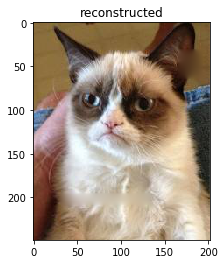

In [8]:
lmbda = 1  # change

uG = GD(g, omega, lmbda)

g = im * omega3

plt.figure()
#plt.subplot(1, 2, 1)
plt.imshow(g)
plt.title('original')
plt.savefig('original.jpg', dpi=900)
#plt.subplot(1, 2, 2)
plt.imshow(uG)
plt.title('reconstructed')
plt.savefig('reconstructed.jpg', dpi=900)

In [9]:
# lmbda = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5]
# ssd = []

# for l in range(len(lmbda)):
#     print(l)
#     g = im * omega3
    
#     uG = GD(g, omega, lmbda[l])
#     ssd.append(GetSSD(im, uG))

# plt.figure(figsize=(20,10))
# plt.plot(lmbda, ssd)
# plt.title('Sum of square difference')
# plt.xlabel('lambda')
# plt.ylabel('SSD')
# plt.savefig('lambda_SSD', dpi=300)

# lmbda_min = argmin(ssd)
# print("\nminimum with lambda of %.2f" % lmbda[lmbda_min])

## (b) Linearization + Gauss-Seidel

In [10]:
def Hessian_matrix(u):
    # let 'u' be the known image
    m, n, *_ = u.shape
    
    # define the coordinates of a neighborhood around each pixel 
    # (center, north, south, west, east, north-west, north-east, south-west, south-east)
    # there are 9 possible neighbors
    rows = zeros((9, m * n))
    cols = zeros((9, m * n))
    vals = zeros((9, m * n))

    for i in range(n):
        for j in range(m):
            # center pixel (i, j)
            rows[0, i * m + j] = i * m + j
            cols[0, i * m + j] = i * m + j
            if(j, i == 0):    
                vals[0, i * m + j] = 4  # here change the value (could depend on 'u')
            else:
                vals[0, i * m + j]  = 1
            
            # northern pixel (i, j - 1)
            rows[1, i * m + j] = i * m + j
            cols[1, i * m + j] = i * m + max(j - 1, 0)
            if(j, i == 0):    
                vals[1, i * m + j] = -1  # here change the value (could depend on 'u')
            else:
                vals[1, i * m + j]  = 0
            
            # southern pixel (i, j + 1)
            rows[2, i * m + j] = i * m + j
            cols[2, i * m + j] = i * m + min(j + 1, m - 1)
            if(j, i == 0):
                vals[2, i * m + j] = -1  # here change the value (could depend on 'u')
            else:
                vals[2, i * m + j]  = 0
            
            # western pixel  (i - 1, j)
            rows[3, i * m + j] = i * m + j
            cols[3, i * m + j] = max(i - 1, 0) * m + j
            if(j, i == 0):
                vals[3, i * m + j] = -1  # here change the value (could depend on 'u')
            else:
                vals[3, i * m + j]  = 0
            
            # eastern pixel  (i + 1, j)
            rows[4, i * m + j] = i * m + j
            cols[4, i * m + j] = min(i + 1, n - 1) * m + j
            if(j, i == 0):
                vals[4, i * m + j] = -1  # here change the value (could depend on 'u')
            else:
                vals[4, i * m + j]  = 0
                
            # north-western pixel (i - 1, j - 1)
            rows[5, i * m + j] = i * m + j
            cols[5, i * m + j] = max(i - 1, 0) * m + max(j - 1, 0)
            vals[5, i * m + j] = 0  # here change the value (could depend on 'u')
            
            # north-eastern pixel (i + 1, j - 1)
            rows[6, i * m + j] = i * m + j
            cols[6, i * m + j] = min(i + 1, n - 1) * m + max(j - 1, 0)
            vals[6, i * m + j] = 0  # here change the value (could depend on 'u')
            
            # south-western pixel (i - 1, j + 1)
            rows[7, i * m + j] = i * m + j
            cols[7, i * m + j] = max(i - 1, 0) * m + min(j + 1, m - 1)
            vals[7, i * m + j] = 0  # here change the value (could depend on 'u')
            
            # south-eastern pixel  (i + 1, j + 1)
            rows[8, i * m + j] = i * m + j
            cols[8, i * m + j] = min(i + 1, n - 1) * m + min(j + 1, m - 1)
            vals[8, i * m + j] = 0  # here change the value (could depend on 'u')

    # generate a sparse matrix
    rows = rows.reshape(-1)
    cols = cols.reshape(-1)
    vals = vals.reshape(-1)
    A = sparse.csr_matrix((vals, (rows, cols)), shape=(n * m, n * m))
    return A

In [11]:
def LGS(g, omega, lmbda):
    
    u = g
    E = g

    omegai = 1-omega
    
    energy = zeros(600)
    
    # separete colors
    red   = u[:, :, 0]
    green = u[:, :, 1]
    blue  = u[:, :, 2]
    
    for i in range (600):
        
        print(i)
        
        rD1 = GetD1(red,   g[:, :,0], omega)
        gD1 = GetD1(green, g[:, :,1], omega)
        bD1 = GetD1(blue,  g[:, :,2], omega)
        
        rD2 = GetD2(red,   lmbda)
        gD2 = GetD2(green, lmbda)
        bD2 = GetD2(blue,  lmbda)
        
        rGrad = (rD1 + rD2) * omegai
        gGrad = (gD1 + gD2) * omegai
        bGrad = (bD1 + bD2) * omegai
            
        Ar = Hessian_matrix(red)
        Ag = Hessian_matrix(green)
        Ab = Hessian_matrix(blue)
        
        Lr = sparse.tril(Ar,0)
        Lg = sparse.tril(Ag,0)
        Lb = sparse.tril(Ab,0)
        
        Ur = sparse.triu(Ar,1)
        Ug = sparse.triu(Ag,1)
        Ub = sparse.triu(Ab,1)

        rGradLin = reshape(rGrad,(size(rGrad),1))
        gGradLin = reshape(gGrad,(size(gGrad),1))
        bGradLin = reshape(bGrad,(size(bGrad),1))

        redLin   = reshape(red,  (size(red)  ,1))
        greenLin = reshape(green,(size(green),1))
        blueLin  = reshape(blue, (size(blue) ,1))
        
        br = Ar * redLin   - rGradLin
        bg = Ag * greenLin - gGradLin
        bb = Ab * blueLin  - bGradLin

        #solve for the new value of u
        redLin   = sparse.linalg.spsolve(Lr,(br - Ur * redLin))
        greenLin = sparse.linalg.spsolve(Lg,(bg - Ug * greenLin))
        blueLin  = sparse.linalg.spsolve(Lb,(bb - Ub * blueLin))

        # Rearrange the vectorize color channel and gradient in matrix form 
        red   = reshape(redLin,   (shape(g[:, :, 0])))
        green = reshape(greenLin, (shape(g[:, :, 1])))
        blue  = reshape(blueLin,  (shape(g[:, :, 2])))
        
        rGrad = reshape(rGradLin, (shape(g[:, :, 0])))
        gGrad = reshape(gGradLin, (shape(g[:, :, 1])))
        bGrad = reshape(bGradLin, (shape(g[:, :, 2])))
        
        # calculate energy       
        E[:, :, 0] = red
        E[:, :, 1] = green
        E[:, :, 2] = blue
        
        energy[i]= GetEnergy(E,g,omega)
            
        # show 5 images during the process
        if i ==1:         
            u[:, :, 0] = red
            u[:, :, 1] = green
            u[:, :, 2] = blue
            
            plt.imshow(u, interpolation='nearest', aspect='equal')
            plt.title('1th iteration')
            plt.savefig('LGSiteration1.jpg', dpi=900)
            
        #display 250th iteration
        if i == 150:
            u[:, :, 0] = red
            u[:, :, 1] = green
            u[:, :, 2] = blue
                        
            plt.imshow(u, interpolation='nearest', aspect='equal')
            plt.title('150th iteration')
            plt.savefig('LGSiteration150.jpg', dpi=900)
            
        #display 500 iteration
        if i == 300:
            #plt.subplot(3, 2, 3)    
            u[:, :, 0] = red
            u[:, :, 1] = green
            u[:, :, 2] = blue
            
            plt.imshow(u, interpolation='nearest', aspect='equal')
            plt.title('300th iteration') 
            plt.savefig('LGSiteration300.jpg', dpi=900)
            
        #display 750 iteration
        if i == 450:
            #plt.subplot(3, 2, 4)    
            u[:, :, 0] = red
            u[:, :, 1] = green
            u[:, :, 2] = blue

            plt.imshow(u, interpolation='nearest', aspect='equal')
            plt.title('450th iteration')
            plt.savefig('LGSiteration450.jpg', dpi=900)
        
        #display 1000 iteration
        if i == 600:
            #plt.subplot(3, 2, 5)    
            u[:, :,0] = red;
            u[:, :,1] = green;
            u[:, :,2] = blue;

            plt.imshow(u, interpolation='nearest', aspect='equal')
            plt.title('600th iteration')
            plt.savefig('LGSiteration600.jpg', dpi=900)
        
    u[:, :, 0] = red
    u[:, :, 1] = green
    u[:, :, 2] = blue
    
    fig2 = plt.figure()
    plt.plot(energy)
    plt.title('energy curve')
    fig2.savefig('LGSenergyCurve.jpg')
    
    return u

0


C:\Users\administrator\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364


C:\Users\administrator\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in double_scalars
  del sys.path[0]


365
366


C:\Users\administrator\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
C:\Users\administrator\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  


367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733


C:\Users\administrator\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in multiply
  del sys.path[0]
C:\Users\administrator\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
C:\Users\administrator\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\administrator\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
C:\Users\administrator\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  


734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999


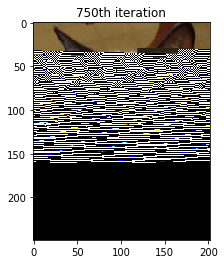

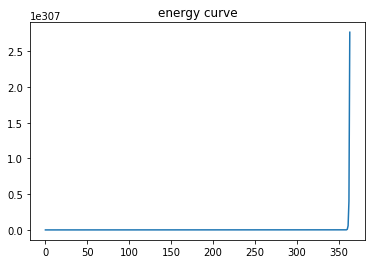

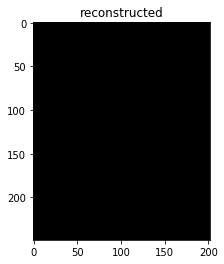

In [12]:
lmbda = 0.08  # change

g = im * omega3

uG = LGS(g, omega, lmbda)

g = im * omega3

plt.figure()
#plt.subplot(1, 2, 1)
plt.imshow(g)
plt.title('original')
plt.savefig('LGSoriginal.jpg', dpi=900)
#plt.subplot(1, 2, 2)
plt.imshow(uG)
plt.title('reconstructed')
plt.savefig('LGSreconstructed.jpg', dpi=900)

## (c) Linearization + SOR

In [13]:
def LSOR(g, omega, lmbda):
    """
    g: color image of size (M, N, 3)
    omega: mask of size (M, N)
    lmbda: regularization parameter

    :returns u: inpainted image of size (M, N, 3)
    """
    u = g
    E = g
    
    omegai = 1 - omega
    
    energy = zeros(600)
    
    # separate color channels:
    red   = u[:, :, 0]
    green = u[:, :, 1]
    blue  = u[:, :, 2]
    
    # set initial guess:
    uRed   = red
    uGreen = green
    uBlue  = blue

    # Set value of w: (w>1 to speed up converging process) (0 < w < 2)
    w=1

    for i in range(600):
        
        print(i)
        
        # Calculate gradient for each color channel:
        rD1 = GetD1(red,   g[:, :,0], omega)
        gD1 = GetD1(green, g[:, :,1], omega)
        bD1 = GetD1(blue,  g[:, :,2], omega)
        
        rD2 = GetD2(red,   lmbda)
        gD2 = GetD2(green, lmbda)
        bD2 = GetD2(blue,  lmbda)
        
        rGrad = (rD1 + rD2) * omegai
        gGrad = (gD1 + gD2) * omegai
        bGrad = (bD1 + bD2) * omegai

        Ar = Hessian_matrix(red)
        Ag = Hessian_matrix(green)
        Ab = Hessian_matrix(blue)

        Lr = sparse.tril(Ar, 0)
        Lg = sparse.tril(Ag, 0)
        Lb = sparse.tril(Ab, 0)
        
        Ur = sparse.triu(Ar,1)
        Ug = sparse.triu(Ag,1)
        Ub = sparse.triu(Ab,1)
        
        Dr = sparse.diags([Lr.diagonal()], [0])
        Dg = sparse.diags([Lg.diagonal()], [0])
        Db = sparse.diags([Lb.diagonal()], [0])
        
        DLr = Lr - Dr
        DLg = Lg - Dg
        DLb = Lb - Db
        
        rGradLin = reshape(rGrad,(size(rGrad),1))
        gGradLin = reshape(gGrad,(size(gGrad),1))
        bGradLin = reshape(bGrad,(size(bGrad),1))
        
        redLin   = reshape(red,  (size(red),1))
        greenLin = reshape(green,(size(green),1))
        blueLin  = reshape(blue, (size(blue),1))
        
        br = Ar * redLin   - rGradLin
        bg = Ag * greenLin - gGradLin
        bb = Ab * blueLin  - bGradLin
        
        
        #solve for the new value of u
        redLin   = sparse.linalg.spsolve(Dr + w * DLr,(w * br - (w * Ur + (w-1) * Dr) * redLin))
        greenLin = sparse.linalg.spsolve(Dg + w * DLg,(w * bg - (w * Ug + (w-1) * Dg) * greenLin))
        blueLin  = sparse.linalg.spsolve(Db + w * DLb,(w * bb - (w * Ub + (w-1) * Db) * blueLin))
        
        # Rearrange the vectorize color channel and gradient in matrix form 
        red   = reshape(redLin,   (shape(g[:, :, 0])))
        green = reshape(greenLin, (shape(g[:, :, 1])))
        blue  = reshape(blueLin,  (shape(g[:, :, 2])))
        
        rGrad = reshape(rGradLin, (shape(g[:, :, 0])))
        gGrad = reshape(gGradLin, (shape(g[:, :, 1])))
        bGrad = reshape(bGradLin, (shape(g[:, :, 2])))
        
        # calculate energy       
        E[:, :, 0] = red
        E[:, :, 1] = green
        E[:, :, 2] = blue
        
        energy[i]= GetEnergy(E,g,omega)
            
        # show 5 images during the process
        if i ==1:         
            u[:, :, 0] = red
            u[:, :, 1] = green
            u[:, :, 2] = blue
            
            plt.imshow(u, interpolation='nearest', aspect='equal')
            plt.title('1th iteration')
            plt.savefig('LSORiteration1.jpg', dpi=900)
            
        #display 250th iteration
        if i == 150:
            u[:, :, 0] = red
            u[:, :, 1] = green
            u[:, :, 2] = blue
                        
            plt.imshow(u, interpolation='nearest', aspect='equal')
            plt.title('150th iteration')
            plt.savefig('LSORiteration150.jpg', dpi=900)
            
        #display 500 iteration
        if i == 300:
            #plt.subplot(3, 2, 3)    
            u[:, :, 0] = red
            u[:, :, 1] = green
            u[:, :, 2] = blue
            
            plt.imshow(u, interpolation='nearest', aspect='equal')
            plt.title('300th iteration') 
            plt.savefig('LSORiteration300.jpg', dpi=900)
            
        #display 750 iteration
        if i ==450:
            #plt.subplot(3, 2, 4)    
            u[:, :, 0] = red
            u[:, :, 1] = green
            u[:, :, 2] = blue

            plt.imshow(u, interpolation='nearest', aspect='equal')
            plt.title('450th iteration')
            plt.savefig('LSORiteration450.jpg', dpi=900)
        
        #display 1000 iteration
        if i == 600:
            #plt.subplot(3, 2, 5)    
            u[:, :,0] = red;
            u[:, :,1] = green;
            u[:, :,2] = blue;

            plt.imshow(u, interpolation='nearest', aspect='equal')
            plt.title('600th iteration')
            plt.savefig('LSORiteration600.jpg', dpi=900)
        
    u[:, :, 0] = red
    u[:, :, 1] = green
    u[:, :, 2] = blue
    
    fig2 = plt.figure()
    plt.plot(energy)
    plt.title('energy curve')
    fig2.savefig('LSORenergyCurve.jpg')

    return u
    

0
1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364


C:\Users\administrator\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in double_scalars
  del sys.path[0]


365
366


C:\Users\administrator\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
C:\Users\administrator\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  


367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733


C:\Users\administrator\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in multiply
  del sys.path[0]


734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983


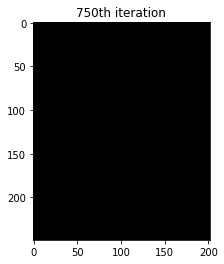

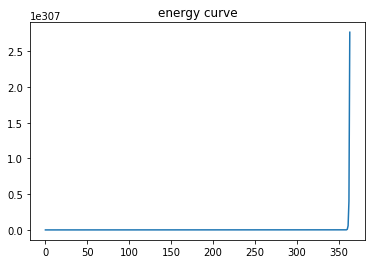

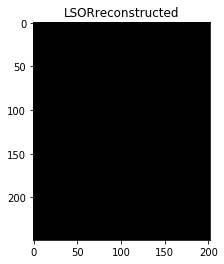

In [14]:
lmbda = 0.08  # change

g = im * omega3

uG = LSOR(g, omega, lmbda)

g = im * omega3

plt.figure()
#plt.subplot(1, 2, 1)
plt.imshow(g)
plt.title('LSORoriginal')
plt.savefig('LSORoriginal.jpg', dpi=900)
#plt.subplot(1, 2, 2)
plt.imshow(uG)
plt.title('LSORreconstructed')
plt.savefig('LSORreconstructed.jpg', dpi=900)